# Testing - Explanation Credibility (Only Categorical Attribute)
## Attributes used to generate Rule : all Attributes
In this code, we aim to validate the explanations generated by the RDR model, which has been trained to imitate the original model. These explanations will be evaluated by an expert in the relevant field, specifically a **dentist**, to ensure its credibility.

* dataset : Dental implant failure
* source : https://doi.org/10.3390/app8050698
* Expert : Devy Yasodhara Lee

In [58]:
import sys
sys.path.append('../src/')
from rdr import RDR

In [59]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn import metrics

pd.options.display.max_columns = None
pd.options.display.max_rows = None

## Import Model Libraries

In [60]:
from sklearn.ensemble import RandomForestClassifier

## 1. Load dataset

### 1.1. Load the dataset and store it in a variable named **df**

In [61]:
df = pd.read_csv("../data/dental_implant_failure.csv")
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 747 entries, 0 to 746
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Age                           739 non-null    float64
 1   Gender                        747 non-null    int64  
 2   Systemic disease              741 non-null    float64
 3   Factors of missing            741 non-null    float64
 4   Tobacco smoking               719 non-null    float64
 5   Betel nut Chewing             719 non-null    float64
 6   Alcohol consumption           719 non-null    float64
 7   Departments                   744 non-null    float64
 8   Surgeon experience            744 non-null    float64
 9   Location of implant           747 non-null    int64  
 10  Bone density                  743 non-null    float64
 11  Timing of implant placement   740 non-null    float64
 12  Ridge augmentation            732 non-null    float64
 13  Maxil

None

### 1.2. Clean dataset

In [62]:
df.drop(columns=['Departments',
                 "Betel nut Chewing",
                 "Alcohol consumption",
                 "Surgeon experience",
                 "Angle of abutment"], inplace=True)
df.dropna(inplace=True)
display(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 701 entries, 0 to 746
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Age                           701 non-null    float64
 1   Gender                        701 non-null    int64  
 2   Systemic disease              701 non-null    float64
 3   Factors of missing            701 non-null    float64
 4   Tobacco smoking               701 non-null    float64
 5   Location of implant           701 non-null    int64  
 6   Bone density                  701 non-null    float64
 7   Timing of implant placement   701 non-null    float64
 8   Ridge augmentation            701 non-null    float64
 9   Maxillary sinus augmentation  701 non-null    float64
 10  Implant system                701 non-null    int64  
 11  Fixture length                701 non-null    float64
 12  Fixture width                 701 non-null    float64
 13  Types of p

None

## 2. Create RDR model

### 2.1. Define categorical attributes
number of categorical attributes : 16

In [63]:
categorical_attr = [
    "Gender",
    "Systemic disease",
    "Factors of missing",
    "Tobacco smoking",
    "Location of implant",
    "Bone density",
    "Timing of implant placement",
    "Ridge augmentation",
    "Maxillary sinus augmentation",
    "Implant system",
    "Types of prosthesis",
    "Prosthesis fixation",
    "Dental implant failure"]

df = df[categorical_attr]

### 2.2. Define features and label and split dataset
train/test ratio = 80 : 20

In [64]:
label = df['Dental implant failure']
features = df.drop('Dental implant failure', axis=1)

X_train, X_test, y_train, y_test = train_test_split(features,
                                                    label,
                                                    test_size=0.2,
                                                    random_state=42)

### 2.3. Oversampling with Synthetic Minority Oversampling Technique (SMOTE) to balance the train dataset

In [65]:
print(f"Before oversampling :\n{y_train.value_counts()}\n")

X_train, y_train = SMOTE().fit_resample(X_train, y_train)

print(f"After oversampling :\n{y_train.value_counts()}\n")

Before oversampling :
Dental implant failure
1    484
0     76
Name: count, dtype: int64

After oversampling :
Dental implant failure
0    484
1    484
Name: count, dtype: int64



### 2.4. Train Decision Tree Classifier model

In [66]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

### 2.5. Create Prediction dataset
Use the original dataset to make predictions with the decision tree classifier (dtf).

In [67]:
predicted_label = rf.predict(features)

### 2.6. Train RDR model by using original dataset and predicted label

In [68]:
rdr = RDR(
        antecedent="1",
        categorical_attr=categorical_attr,
        total_precedent= 12)

rf_rdr = rdr.fit(features, pd.DataFrame(predicted_label))

In [69]:
# PREDICT USING DECISION TREE AND RDR
rf_pred = rf.predict(X_test)
rf_rdr_pred = rf_rdr.predict(X_test)

print(f"RF accuracy score: {metrics.accuracy_score(y_test, rf_pred)}")
print(f"RDR accuracy score: {metrics.accuracy_score(y_test, rf_rdr_pred)}")
print(f"RDR imitation accuracy score: {metrics.accuracy_score(rf_pred, rf_rdr_pred)}")

RF accuracy score: 0.75177304964539
RDR accuracy score: 0.75177304964539
RDR imitation accuracy score: 1.0


In [70]:
sample = X_test.sample(20, random_state=42)
sample_label = y_test.loc[sample.index]

In [72]:
sample_label

731    0
426    1
543    0
616    1
505    0
326    1
719    0
75     1
120    1
702    1
441    0
562    1
342    1
290    1
226    1
24     1
87     0
66     0
599    1
503    1
Name: Dental implant failure, dtype: int64

,Gender,Systemic disease,Factors of missing,Tobacco smoking,Location of implant,Bone density,Timing of implant placement,Ridge augmentation,Maxillary sinus augmentation,Implant system,Types of prosthesis,Prosthesis fixation
731,0,1.0,1.0,0.0,4,3.0,2.0,1.0,0.0,1,0.0,0.0


Index                   : 731
Actual label            : 0
Predicted label         : [1]
Predicted label with RDR: [1.]


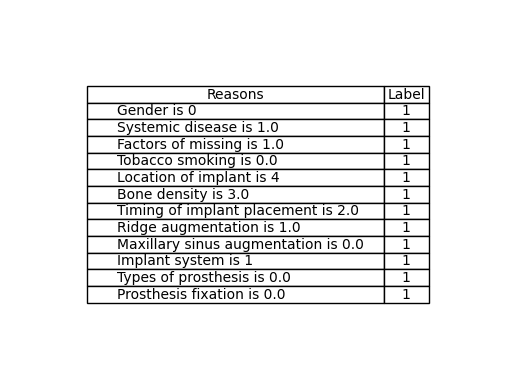

,Gender,Systemic disease,Factors of missing,Tobacco smoking,Location of implant,Bone density,Timing of implant placement,Ridge augmentation,Maxillary sinus augmentation,Implant system,Types of prosthesis,Prosthesis fixation
426,0,1.0,1.0,0.0,5,2.0,2.0,0.0,0.0,0,0.0,1.0


Index                   : 426
Actual label            : 1
Predicted label         : [1]
Predicted label with RDR: [1.]


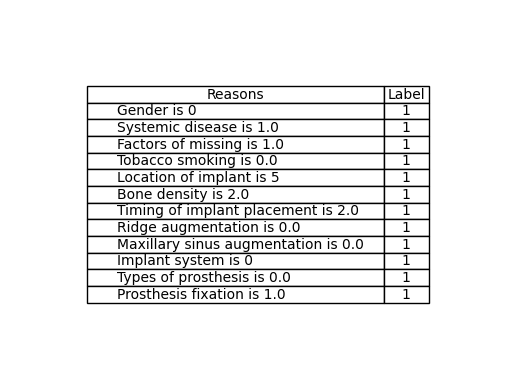

,Gender,Systemic disease,Factors of missing,Tobacco smoking,Location of implant,Bone density,Timing of implant placement,Ridge augmentation,Maxillary sinus augmentation,Implant system,Types of prosthesis,Prosthesis fixation
543,0,0.0,3.0,0.0,2,4.0,2.0,0.0,1.0,0,0.0,0.0


Index                   : 543
Actual label            : 0
Predicted label         : [1]
Predicted label with RDR: [1.]


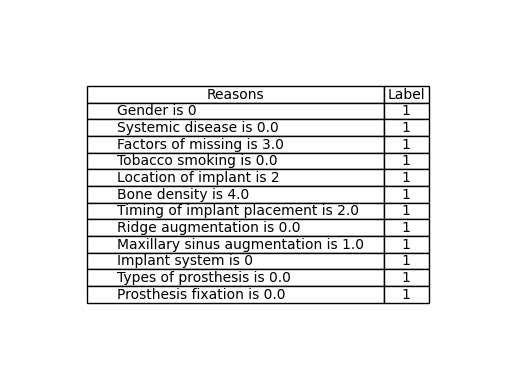

,Gender,Systemic disease,Factors of missing,Tobacco smoking,Location of implant,Bone density,Timing of implant placement,Ridge augmentation,Maxillary sinus augmentation,Implant system,Types of prosthesis,Prosthesis fixation
616,0,0.0,3.0,0.0,0,3.0,2.0,1.0,0.0,0,0.0,0.0


Index                   : 616
Actual label            : 1
Predicted label         : [0]
Predicted label with RDR: [0.]


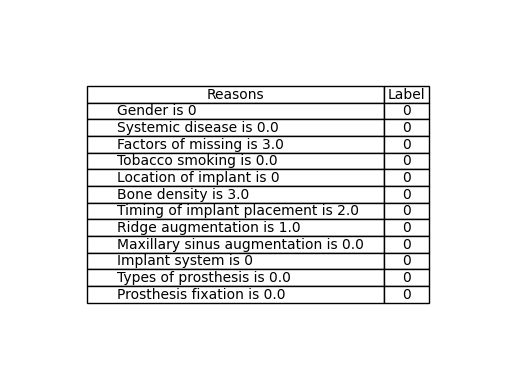

,Gender,Systemic disease,Factors of missing,Tobacco smoking,Location of implant,Bone density,Timing of implant placement,Ridge augmentation,Maxillary sinus augmentation,Implant system,Types of prosthesis,Prosthesis fixation
505,0,0.0,3.0,0.0,0,3.0,2.0,0.0,0.0,0,0.0,0.0


Index                   : 505
Actual label            : 0
Predicted label         : [1]
Predicted label with RDR: [1.]


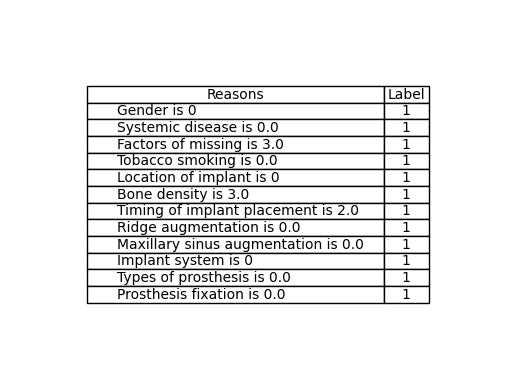

,Gender,Systemic disease,Factors of missing,Tobacco smoking,Location of implant,Bone density,Timing of implant placement,Ridge augmentation,Maxillary sinus augmentation,Implant system,Types of prosthesis,Prosthesis fixation
326,0,0.0,2.0,0.0,2,3.0,2.0,0.0,2.0,0,0.0,0.0


Index                   : 326
Actual label            : 1
Predicted label         : [0]
Predicted label with RDR: [0.]


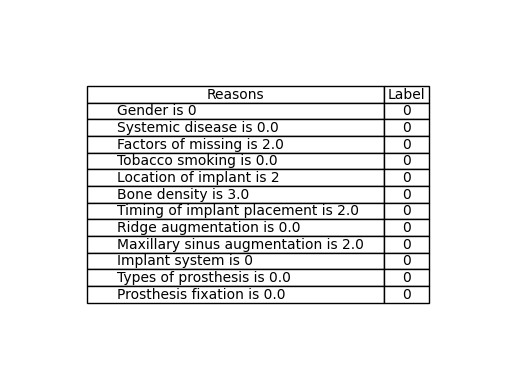

,Gender,Systemic disease,Factors of missing,Tobacco smoking,Location of implant,Bone density,Timing of implant placement,Ridge augmentation,Maxillary sinus augmentation,Implant system,Types of prosthesis,Prosthesis fixation
719,0,1.0,2.0,0.0,2,3.0,2.0,0.0,0.0,0,0.0,0.0


Index                   : 719
Actual label            : 0
Predicted label         : [1]
Predicted label with RDR: [1.]


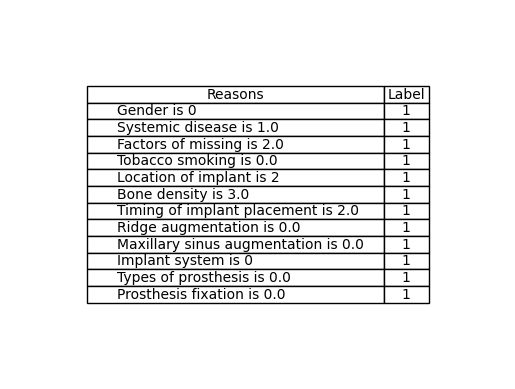

,Gender,Systemic disease,Factors of missing,Tobacco smoking,Location of implant,Bone density,Timing of implant placement,Ridge augmentation,Maxillary sinus augmentation,Implant system,Types of prosthesis,Prosthesis fixation
75,0,0.0,1.0,0.0,1,3.0,2.0,1.0,0.0,1,0.0,0.0


Index                   : 75
Actual label            : 1
Predicted label         : [0]
Predicted label with RDR: [0.]


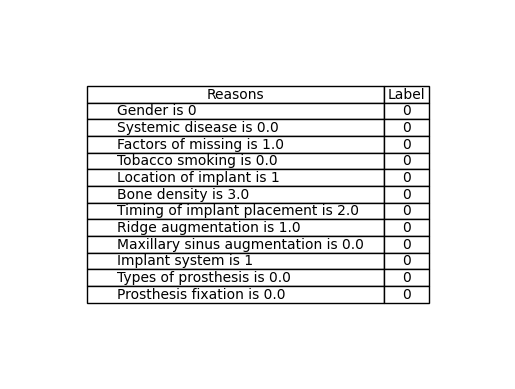

,Gender,Systemic disease,Factors of missing,Tobacco smoking,Location of implant,Bone density,Timing of implant placement,Ridge augmentation,Maxillary sinus augmentation,Implant system,Types of prosthesis,Prosthesis fixation
120,0,3.0,2.0,0.0,2,3.0,2.0,1.0,2.0,1,0.0,0.0


Index                   : 120
Actual label            : 1
Predicted label         : [1]
Predicted label with RDR: [1.]


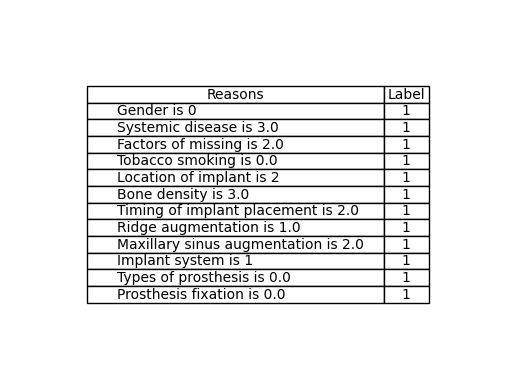

,Gender,Systemic disease,Factors of missing,Tobacco smoking,Location of implant,Bone density,Timing of implant placement,Ridge augmentation,Maxillary sinus augmentation,Implant system,Types of prosthesis,Prosthesis fixation
702,0,0.0,2.0,0.0,2,3.0,2.0,0.0,2.0,1,0.0,0.0


Index                   : 702
Actual label            : 1
Predicted label         : [1]
Predicted label with RDR: [1.]


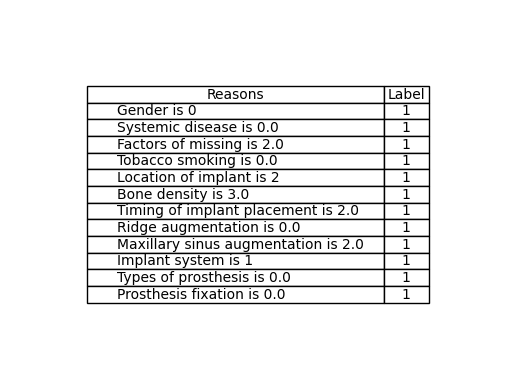

,Gender,Systemic disease,Factors of missing,Tobacco smoking,Location of implant,Bone density,Timing of implant placement,Ridge augmentation,Maxillary sinus augmentation,Implant system,Types of prosthesis,Prosthesis fixation
441,0,2.0,2.0,0.0,2,3.0,2.0,0.0,0.0,1,0.0,0.0


Index                   : 441
Actual label            : 0
Predicted label         : [1]
Predicted label with RDR: [1.]


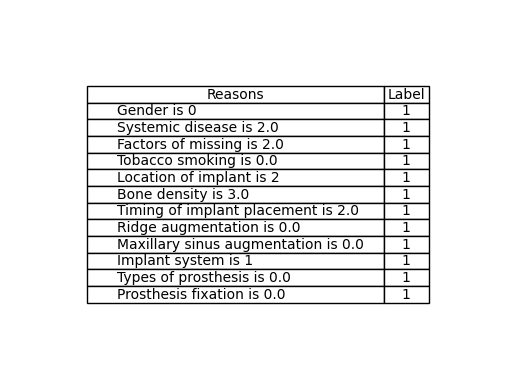

,Gender,Systemic disease,Factors of missing,Tobacco smoking,Location of implant,Bone density,Timing of implant placement,Ridge augmentation,Maxillary sinus augmentation,Implant system,Types of prosthesis,Prosthesis fixation
562,1,0.0,2.0,1.0,5,2.0,2.0,0.0,0.0,5,0.0,0.0


Index                   : 562
Actual label            : 1
Predicted label         : [0]
Predicted label with RDR: [0.]


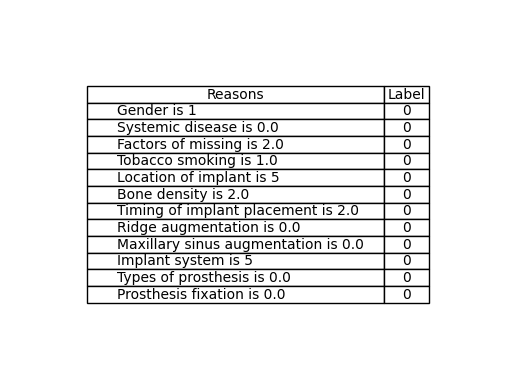

,Gender,Systemic disease,Factors of missing,Tobacco smoking,Location of implant,Bone density,Timing of implant placement,Ridge augmentation,Maxillary sinus augmentation,Implant system,Types of prosthesis,Prosthesis fixation
342,1,0.0,3.0,2.0,5,3.0,2.0,0.0,0.0,0,0.0,0.0


Index                   : 342
Actual label            : 1
Predicted label         : [1]
Predicted label with RDR: [1.]


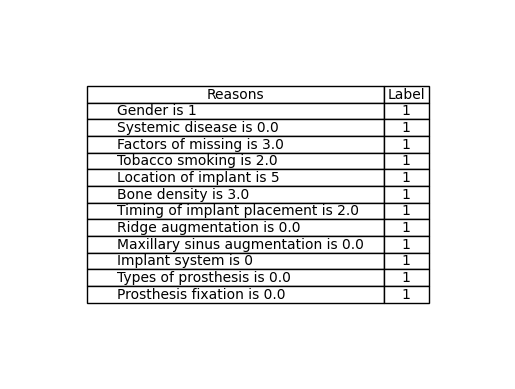

,Gender,Systemic disease,Factors of missing,Tobacco smoking,Location of implant,Bone density,Timing of implant placement,Ridge augmentation,Maxillary sinus augmentation,Implant system,Types of prosthesis,Prosthesis fixation
290,1,0.0,3.0,0.0,2,3.0,2.0,0.0,0.0,0,0.0,0.0


Index                   : 290
Actual label            : 1
Predicted label         : [1]
Predicted label with RDR: [1.]


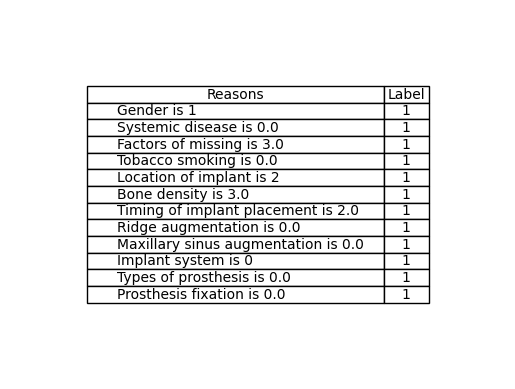

,Gender,Systemic disease,Factors of missing,Tobacco smoking,Location of implant,Bone density,Timing of implant placement,Ridge augmentation,Maxillary sinus augmentation,Implant system,Types of prosthesis,Prosthesis fixation
226,0,0.0,2.0,0.0,5,2.0,2.0,0.0,0.0,0,0.0,0.0


Index                   : 226
Actual label            : 1
Predicted label         : [1]
Predicted label with RDR: [1.]


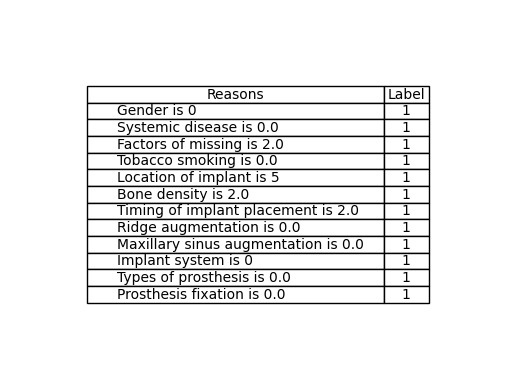

,Gender,Systemic disease,Factors of missing,Tobacco smoking,Location of implant,Bone density,Timing of implant placement,Ridge augmentation,Maxillary sinus augmentation,Implant system,Types of prosthesis,Prosthesis fixation
24,1,0.0,2.0,0.0,5,2.0,2.0,0.0,0.0,0,0.0,0.0


Index                   : 24
Actual label            : 1
Predicted label         : [1]
Predicted label with RDR: [1.]


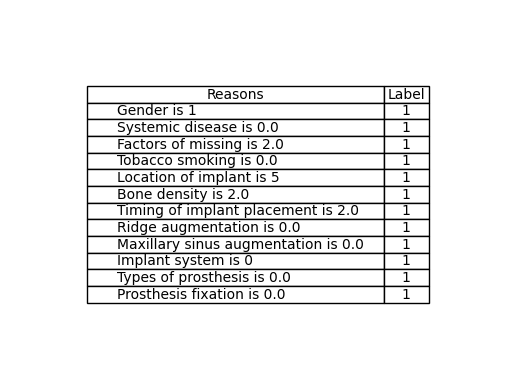

,Gender,Systemic disease,Factors of missing,Tobacco smoking,Location of implant,Bone density,Timing of implant placement,Ridge augmentation,Maxillary sinus augmentation,Implant system,Types of prosthesis,Prosthesis fixation
87,1,0.0,2.0,1.0,2,3.0,2.0,1.0,0.0,1,0.0,0.0


Index                   : 87
Actual label            : 0
Predicted label         : [1]
Predicted label with RDR: [1.]


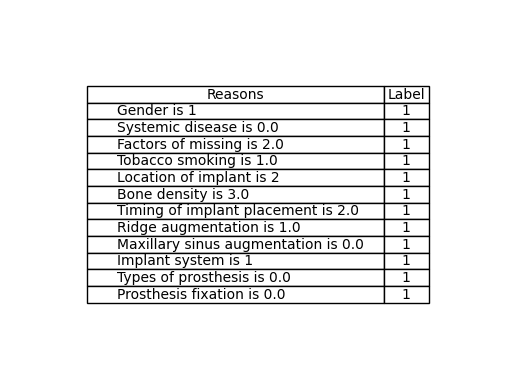

,Gender,Systemic disease,Factors of missing,Tobacco smoking,Location of implant,Bone density,Timing of implant placement,Ridge augmentation,Maxillary sinus augmentation,Implant system,Types of prosthesis,Prosthesis fixation
66,0,0.0,1.0,0.0,5,2.0,2.0,1.0,0.0,1,0.0,0.0


Index                   : 66
Actual label            : 0
Predicted label         : [0]
Predicted label with RDR: [0.]


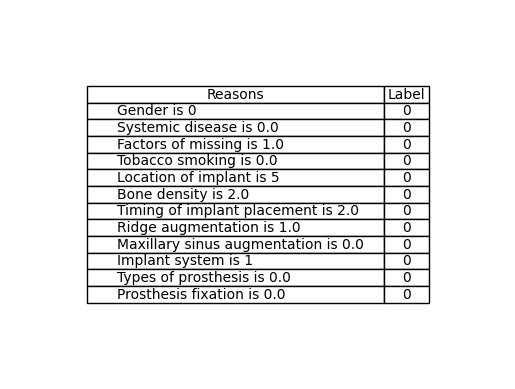

,Gender,Systemic disease,Factors of missing,Tobacco smoking,Location of implant,Bone density,Timing of implant placement,Ridge augmentation,Maxillary sinus augmentation,Implant system,Types of prosthesis,Prosthesis fixation
599,0,0.0,2.0,0.0,3,3.0,2.0,1.0,0.0,0,0.0,0.0


Index                   : 599
Actual label            : 1
Predicted label         : [1]
Predicted label with RDR: [1.]


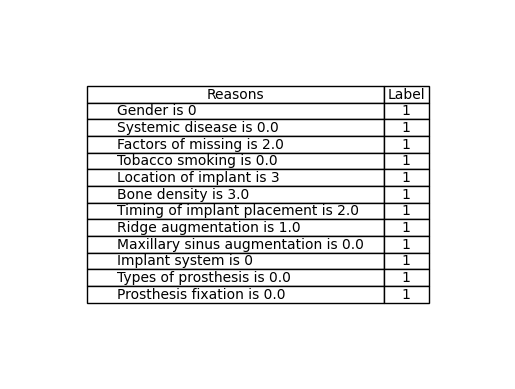

,Gender,Systemic disease,Factors of missing,Tobacco smoking,Location of implant,Bone density,Timing of implant placement,Ridge augmentation,Maxillary sinus augmentation,Implant system,Types of prosthesis,Prosthesis fixation
503,0,0.0,3.0,0.0,0,3.0,2.0,0.0,0.0,0,0.0,0.0


Index                   : 503
Actual label            : 1
Predicted label         : [1]
Predicted label with RDR: [1.]


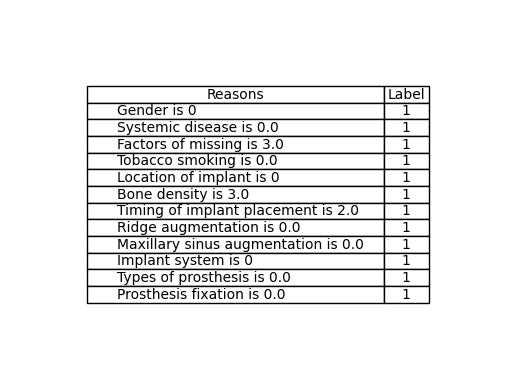

In [73]:
for idx in sample.index:
    display(sample.loc[[idx]])
    print(f"Index                   : {idx}")
    print(f"Actual label            : {sample_label.loc[idx]}")
    print(f"Predicted label         : {rf.predict(sample.loc[[idx]])}")
    print(f"Predicted label with RDR: {rf_rdr.predict(sample.loc[[idx]])}")
    output, reason, cornerstone = rf_rdr.explain_instance(sample.loc[[idx]])